Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/EMA Electricity Forecast/Electricity-Generated (monthly).xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Enabled
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_SetDate
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Method
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_Name
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:212: UserWarning: Unknown type for MSIP_Label_5434c4c7-833e-41e4-b0ab-cdb227a2f6f7_SiteId
  warn(f"Unknown type for {prop.name}")
/usr/

In [4]:
df1.head()

,Month,Electricity Generated (Gwh)
0,1975-01-01,341.8
1,1975-02-01,289.6
2,1975-03-01,342.8
3,1975-04-01,348.6
4,1975-05-01,351.4


In [5]:
df1.dtypes

Month                          datetime64[ns]
Electricity Generated (Gwh)           float64
dtype: object

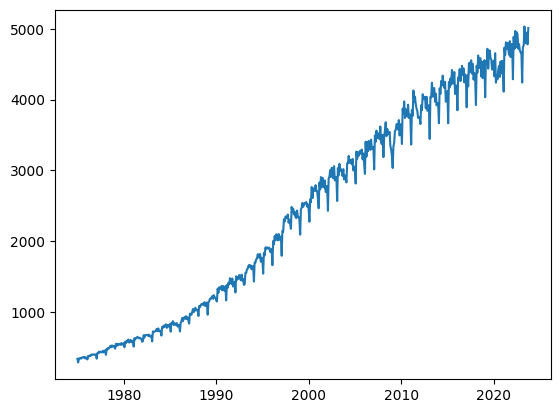

In [6]:
X= df1['Month']
y= df1['Electricity Generated (Gwh)']
plt.plot(X,y)

In [7]:
df2 = df1.copy()
df2.set_index('Month', inplace=True)

df2

,Electricity Generated (Gwh)
Month,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2023-06-01,4797.3
2023-07-01,4931.7
2023-08-01,4945.2


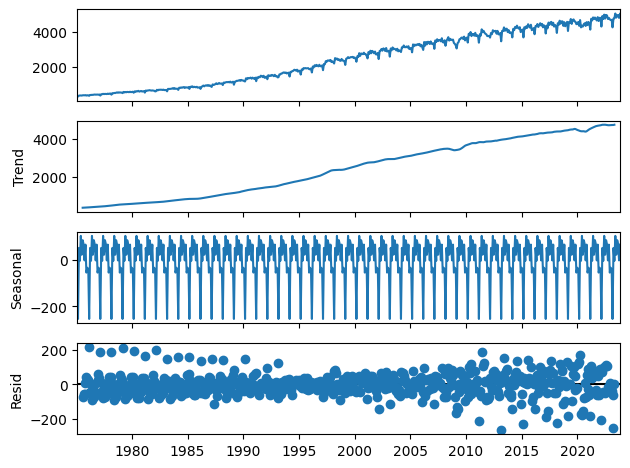

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
df2 = df1.copy()
# Convert 'Month' to datetime
df2['Month'] = pd.to_datetime(df2['Month'])

# Set 'Month' as the index
df2.set_index('Month', inplace=True)

# Resample the data to ensure it fits a monthly frequency.
# This approach fills missing months with NaN, which you might need to handle depending on your analysis needs.
df2_resampled = df2.resample('M').mean()

# Decompose the time series
# Ensure you're working with a series without NaNs or handle NaNs as per your requirement.
decomposition = seasonal_decompose(df2_resampled.dropna(), model='additive')
decomposition.plot()
plt.show()

Step 1: Ensure Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

adfuller(y)[1]  # p-value

0.9843865318090247

**since p-value > 0.05,  null hypothesis of the ADF test (the time series is non-stationary) cannot be rejected at any reasonable significance level. This suggests that the time series is non-stationary and may require differencing to make it stationary before fitting an ARIMA model.**

##Step 1 - Select d

Text(0.5, 1.0, 'second difference')

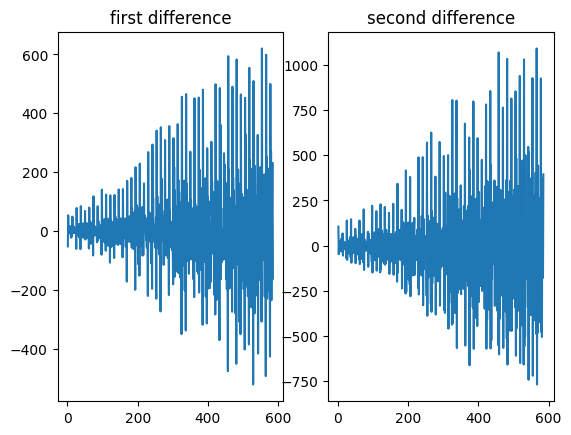

In [10]:
plt.subplot(1,2,1)
# non_differenced_data = pd.Series(y)
yd1 = y.diff().dropna()
yd1.plot();
plt.title('first difference')

plt.subplot(1,2,2)
yd2 = yd1.diff().dropna()
yd2.plot()
plt.title('second difference')

**since there is no significant difference, d=1 is taken**

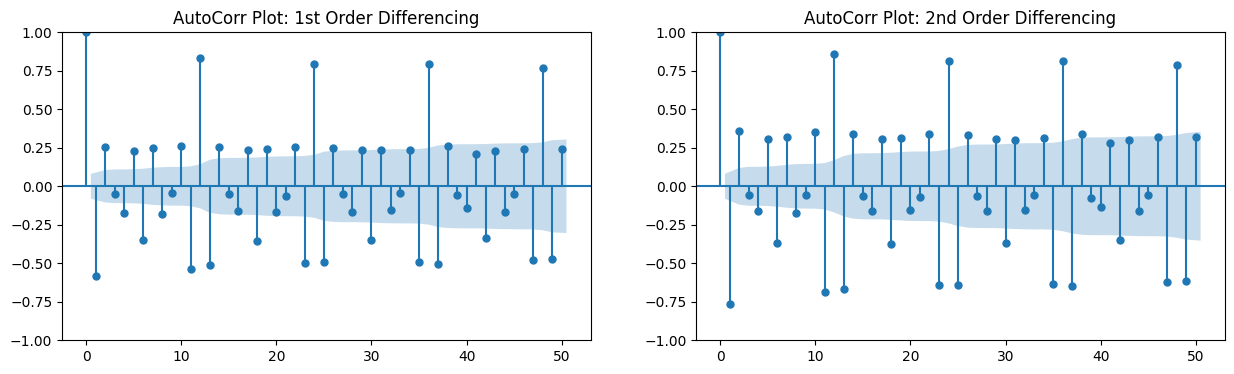

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2,figsize=(15,4))


plot_acf(yd1, lags=50, ax=axes[0]);
axes[0].set_title('AutoCorr Plot: 1st Order Differencing');


plot_acf(yd2, lags=50, ax=axes[1]);
axes[1].set_title('AutoCorr Plot: 2nd Order Differencing');

##Step 2 - Select AR order(p) and MA order(q)

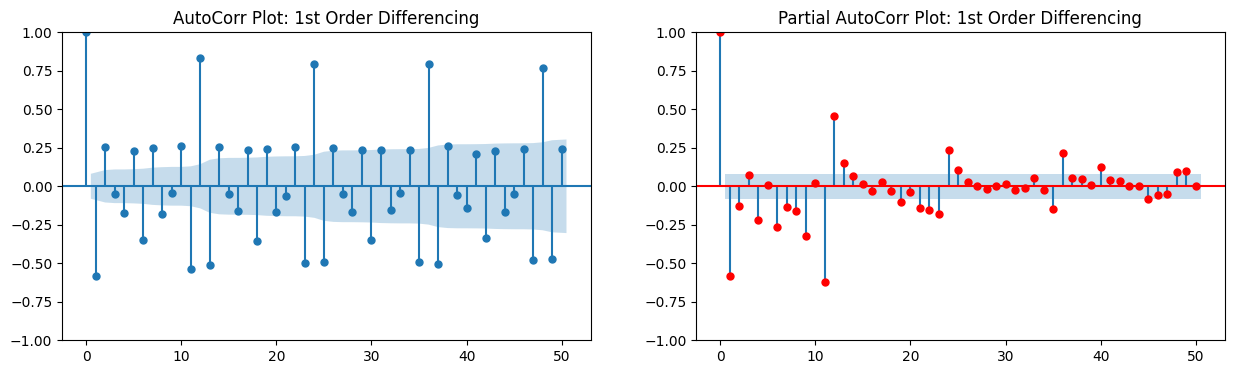

In [12]:
fig, axes = plt.subplots(1, 2,figsize=(15,4))

# ACF / PACF analysis of y_diff linearized
plot_acf(yd1, lags=50, ax=axes[0]);
axes[0].set_title('AutoCorr Plot: 1st Order Differencing');

plot_pacf(yd1, lags=50, ax=axes[1], c='r');
axes[1].set_title('Partial AutoCorr Plot: 1st Order Differencing');

**from preliminary analysis, q=2, p=2**

##Step 3 - Build Model

In [43]:
p=1;
d=2;
q=2;

from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima = ARIMA(y, order=(p,d,q))
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Electricity Generated (Gwh)   No. Observations:                  586
Model:                          ARIMA(1, 2, 2)   Log Likelihood               -3644.541
Date:                         Mon, 26 Feb 2024   AIC                           7297.081
Time:                                 07:37:37   BIC                           7314.561
Sample:                                      0   HQIC                          7303.894
                                         - 586                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4565      0.045    -10.167      0.000      -0.544      -0.368
ma.L1         -1.2003      0.301     -3.992      0.000      -1.790      -0.611
ma.L2          0.2005      0.074      2.716      0.007       0.056       0.345
sigma2      1.522e+04   4654.051      3.270      0.001    6094.821    2.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               132.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              18.22   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00


Optimizing p,d,q

In [44]:
import pmdarima as pm
smodel = pm.auto_arima(y,
                       start_p=1, max_p=2,
                       d=1, max_d = 2,
                       start_q=1, max_q=2,

                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7301.074, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7551.974, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7307.696, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7309.888, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7551.557, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7284.033, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7299.906, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7303.072, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7289.205, Time=0.21 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.318 seconds


**Based on optimization, the best combination of the ARIMA model is: p=2, d=1, q=1**

In [16]:
p=2;
d=1;
q=1;

from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima_base = ARIMA(y, order=(p,d,q))
arima_base = arima_base.fit()
arima_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Electricity Generated (Gwh)   No. Observations:                  586
Model:                          ARIMA(2, 1, 1)   Log Likelihood               -3640.602
Date:                         Mon, 26 Feb 2024   AIC                           7289.205
Time:                                 07:30:19   BIC                           7306.691
Sample:                                      0   HQIC                          7296.020
                                         - 586                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2998      0.118    -11.003      0.000      -1.531      -1.068
ar.L2         -0.5247      0.070     -7.516      0.000      -0.661      -0.388
ma.L1          0.6515      0.126      5.167      0.000       0.404       0.899
sigma2      1.488e+04    653.485     22.770      0.000    1.36e+04    1.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                89.28
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              17.47   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Step 4a - Forecast (dynamic=false, base)
☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

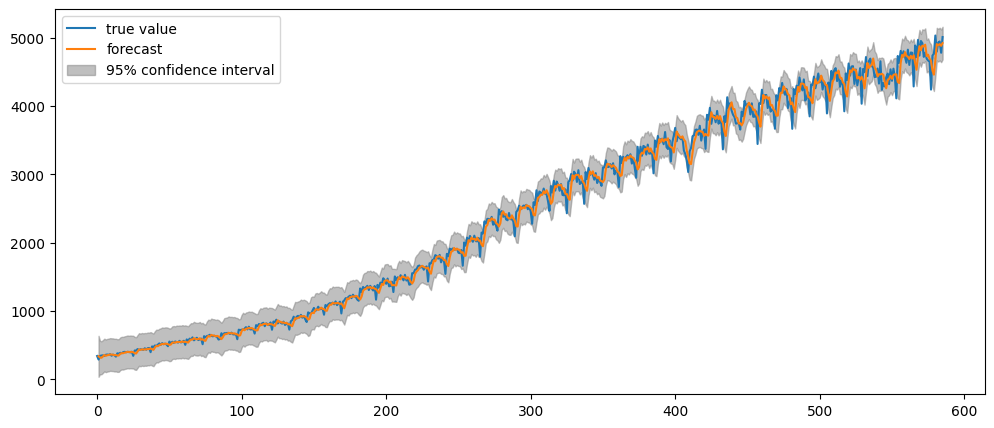

In [17]:
from statsmodels.graphics.tsaplots import plot_predict
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y, label='true value')
plot_predict(arima_base, start=1, ax=axs, dynamic=False);

###Forecast for the next 12 months after Sep 2023 (=point #585)

In [18]:
forecast_base = arima_base.forecast(steps=12)
forecast_base

586    4855.621199
587    4935.876465
588    4912.659427
589    4900.730622
590    4928.417534
591    4898.687395
592    4922.805630
593    4907.054042
594    4914.874641
595    4912.973412
596    4911.341497
597    4914.460257
Name: predicted_mean, dtype: float64

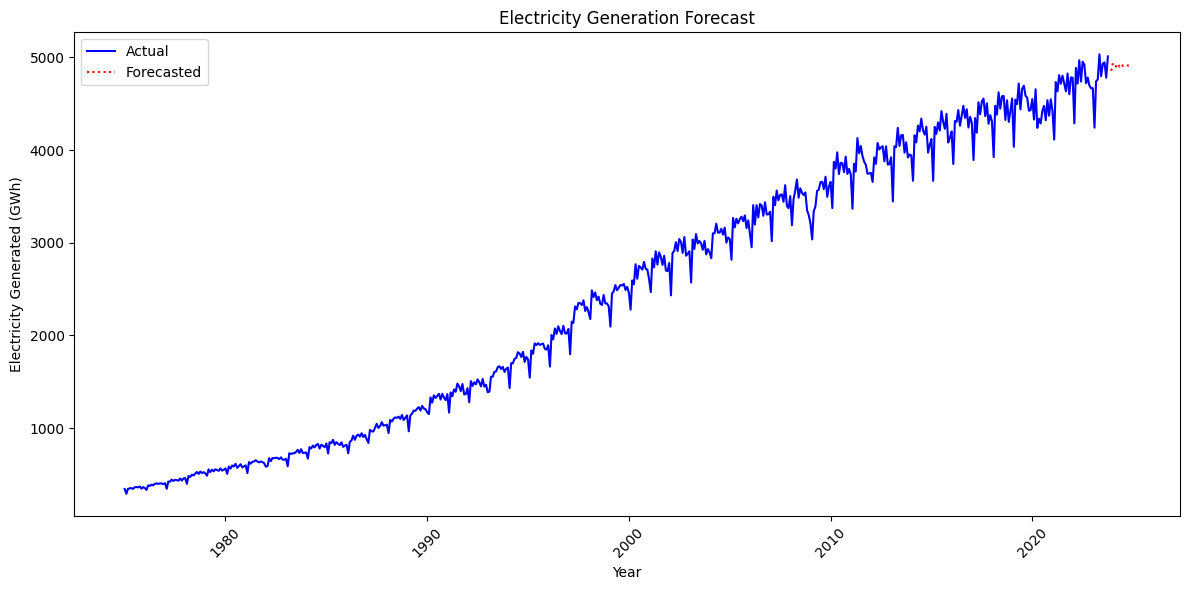

In [49]:
# Creating a dataframe for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq='M')
forecast_base_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_base.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')

plt.plot(forecast_base_df['Month'], forecast_base_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='dotted')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()





Zoom in (last 50 points)

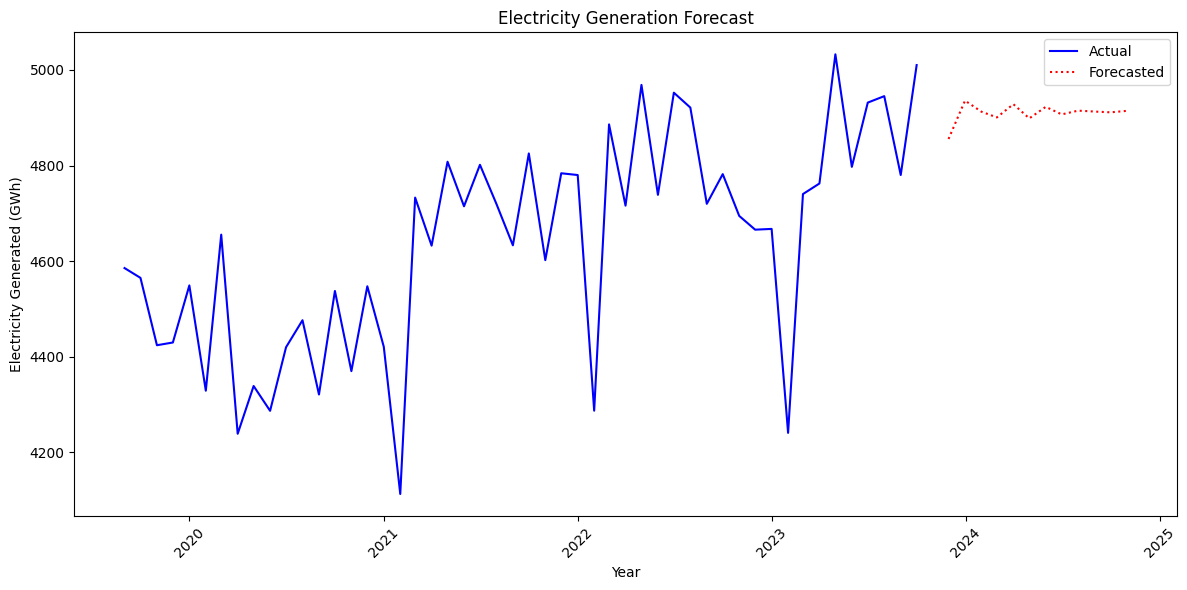

In [50]:
# Creating a dataframe for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq='M')
forecast_base_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_base.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
#plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(df1['Month'].iloc[-50:], df1['Electricity Generated (Gwh)'].iloc[-50:], label='Actual', color='blue')

plt.plot(forecast_base_df['Month'], forecast_base_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='dotted')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [46]:
forecast_base_df

,Month,Forecasted Electricity Generated (Gwh)
0,2023-11-30,4855.621199
1,2023-12-31,4935.876465
2,2024-01-31,4912.659427
3,2024-02-29,4900.730622
4,2024-03-31,4928.417534
5,2024-04-30,4898.687395
6,2024-05-31,4922.805630
7,2024-06-30,4907.054042
8,2024-07-31,4914.874641
9,2024-08-31,4912.973412


## Step 4b - Forecast (dynamic=true)
👉 `dynamic=True` to plot a prediction of the _last 86 values_ in a situation where the model only has _access to data up to 500_. That is to say, the model:
- predicts 501 based on true [1...500]
- then predicts 502 based on [1...500] _plus_ its previously predicted value for 501
- etc...iteratively until 586

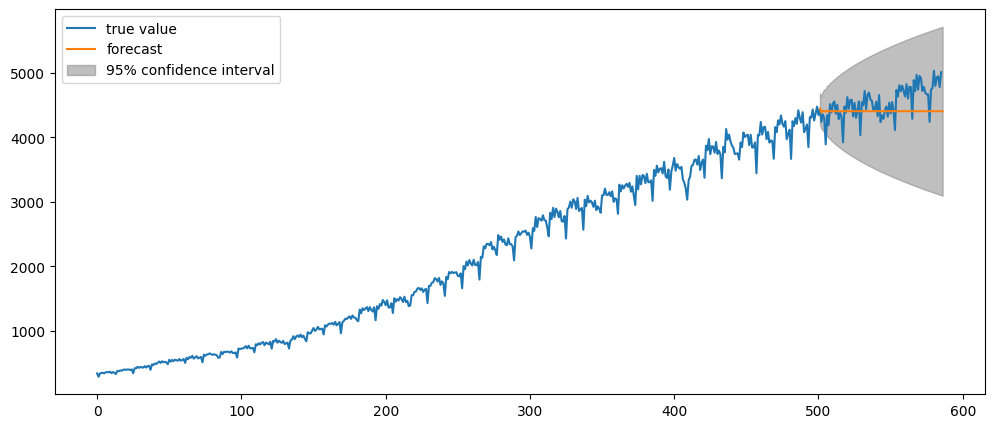

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(y, label='true value')
plot_predict(arima_base, start=501, end=586, ax=axs, dynamic=True);

In [53]:
y.head()

0    341.799988
1    289.600006
2    342.799988
3    348.600006
4    351.399994
Name: Electricity Generated (Gwh), dtype: float32

###Step 4c - Forecast (train-test-split)
👉 train size=500, test size=86

In [57]:
y_train = y[:500]
y_test = y[500:]
arima = ARIMA(y_train, order=(2, 1, 1), trend='t').fit()

In [58]:
y_train

0       341.799988
1       289.600006
2       342.799988
3       348.600006
4       351.399994
          ...     
495    4304.399902
496    4431.100098
497    4261.500000
498    4366.000000
499    4477.000000
Name: Electricity Generated (Gwh), Length: 500, dtype: float32

In [59]:
y_test

500    4345.899902
501    4439.700195
502    4242.100098
503    4357.000000
504    4294.799805
          ...     
581    4797.299805
582    4931.700195
583    4945.200195
584    4780.200195
585    5010.200195
Name: Electricity Generated (Gwh), Length: 86, dtype: float32

In [60]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(y_test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [62]:
forecast

500    4458.273356
501    4454.757650
502    4494.715954
503    4461.142123
504    4516.480362
          ...     
581    5104.675647
582    5163.010525
583    5121.269086
584    5179.541143
585    5137.862485
Name: predicted_mean, Length: 86, dtype: float64

In [25]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(y_train, label='training', color='black')
    plt.plot(y_test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [63]:
print(forecast.shape)
print(y_train.shape)
print(y_test.shape)
print(confidence_int.shape)

(86,)
(500,)
(86,)
(86, 2)


In [27]:
if confidence_int.shape[0] != y_test.shape[0]:
    raise ValueError("Confidence interval and test data have different lengths.")

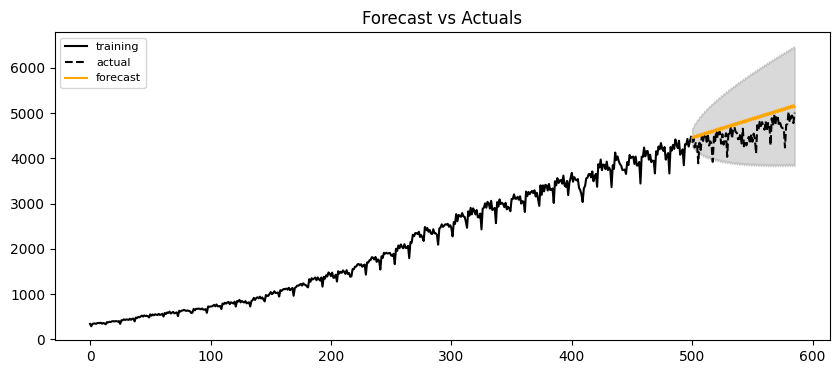

In [64]:
plot_forecast(forecast, y_train, y_test, confidence_int[:,0], confidence_int[:,1])

###Forecast for the next 12 months after Sep 2023 (=point #585)

In [65]:
# Forecast values and confidence intervals
forecast_results_12m = arima.get_forecast(steps=98, alpha=0.05) #last 86 rows (test size) + 12 months after Oct 2023
forecast_12m = forecast_results_12m.predicted_mean
confidence_int_12m = forecast_results_12m.conf_int().values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [66]:
forecast_12m

500    4458.273356
501    4454.757650
502    4494.715954
503    4461.142123
504    4516.480362
          ...     
593    5204.235690
594    5262.194820
595    5220.828894
596    5278.725673
597    5237.422058
Name: predicted_mean, Length: 98, dtype: float64

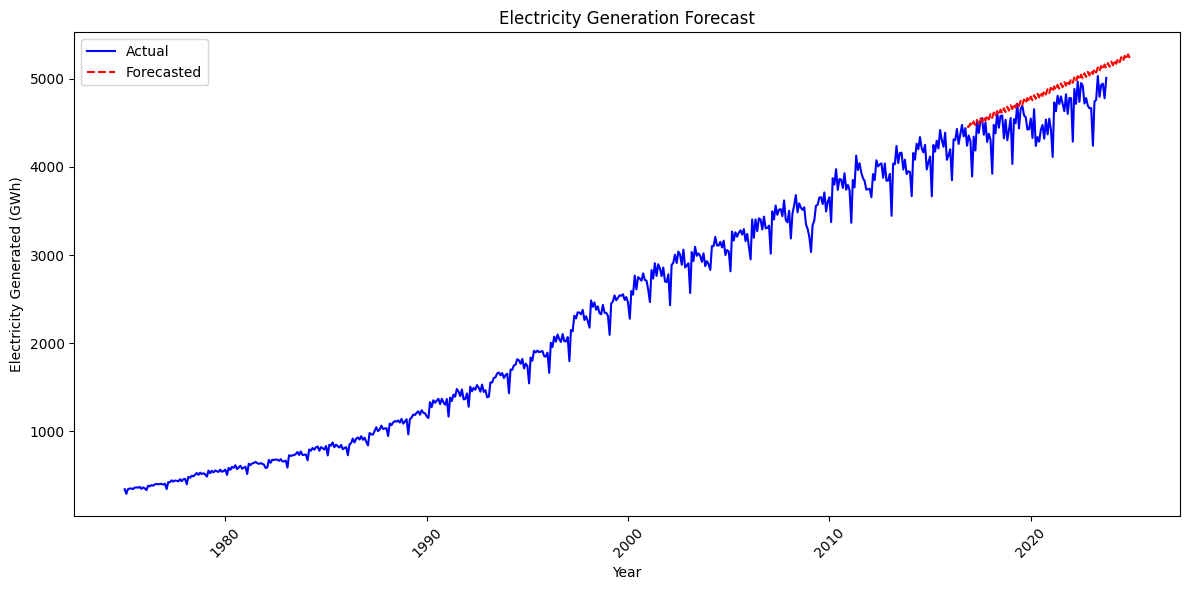

In [95]:
# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-86] + pd.offsets.MonthBegin(1), periods=len(forecast_12m), freq='M')
forecast_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


In [96]:
forecast_12m_df

,Month,Forecasted Electricity Generated (Gwh)
0,2016-10-31,4458.273356
1,2016-11-30,4454.757650
2,2016-12-31,4494.715954
3,2017-01-31,4461.142123
4,2017-02-28,4516.480362
...,...,...
93,2024-07-31,5204.235690
94,2024-08-31,5262.194820
95,2024-09-30,5220.828894
96,2024-10-31,5278.725673


In [97]:
forecast_12m_df.tail(13)

,Month,Forecasted Electricity Generated (Gwh)
85,2023-11-30,5137.862485
86,2023-12-31,5196.071800
87,2024-01-31,5154.455846
88,2024-02-29,5212.602496
89,2024-03-31,5171.049166
90,2024-04-30,5229.133231
91,2024-05-31,5187.642448
92,2024-06-30,5245.664006
93,2024-07-31,5204.235690
94,2024-08-31,5262.194820


#Zoomed in (from Oct 2016 onwards, inclusive)

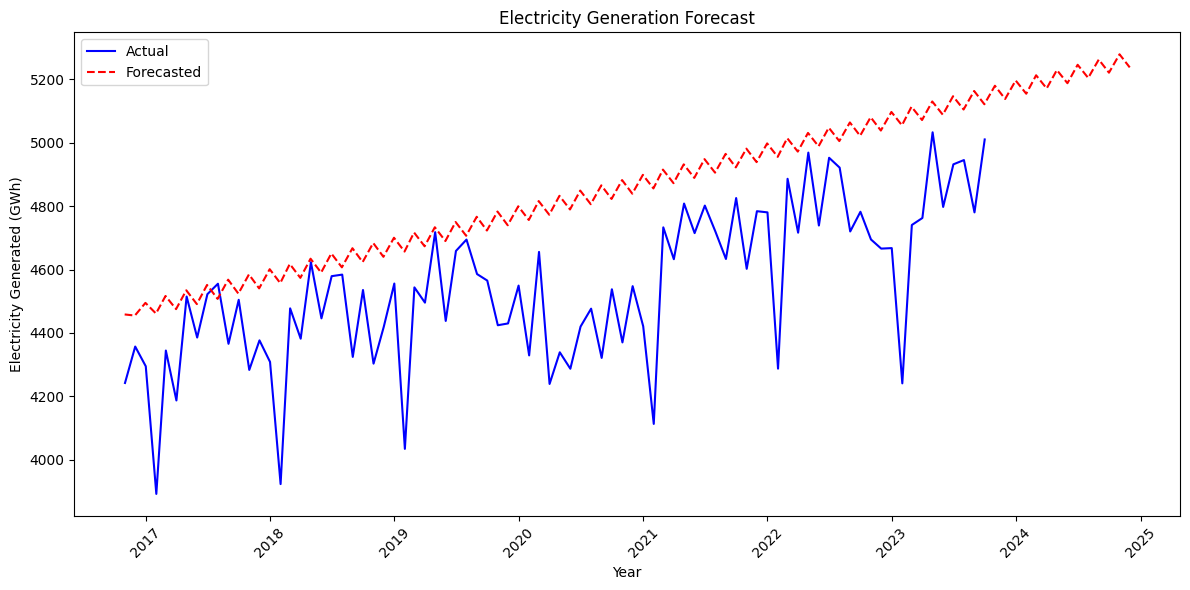

In [103]:
# Creating a DataFrame for the forecasted values to facilitate plotting
forecast_dates = pd.date_range(start=df1['Month'].iloc[-86] + pd.offsets.MonthBegin(1), periods=len(forecast_12m), freq='M')
forecast_12m_df = pd.DataFrame({'Month': forecast_dates, 'Forecasted Electricity Generated (Gwh)': forecast_12m.values})

# Plotting the actual and forecasted electricity generation
plt.figure(figsize=(12, 6))
#plt.plot(df1['Month'], df1['Electricity Generated (Gwh)'], label='Actual', color='blue')
plt.plot(df1['Month'].iloc[-84:], df1['Electricity Generated (Gwh)'].iloc[-84:], label='Actual', color='blue')
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], label='Forecasted', color='red', linestyle='--')
plt.title('Electricity Generation Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Generated (GWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()




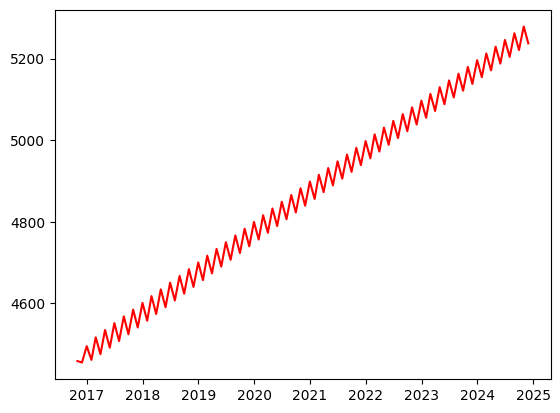

In [104]:
plt.plot(forecast_12m_df['Month'], forecast_12m_df['Forecasted Electricity Generated (Gwh)'], color='red')

In [105]:
forecast_12m_df

,Month,Forecasted Electricity Generated (Gwh)
0,2016-10-31,4458.273356
1,2016-11-30,4454.757650
2,2016-12-31,4494.715954
3,2017-01-31,4461.142123
4,2017-02-28,4516.480362
...,...,...
93,2024-07-31,5204.235690
94,2024-08-31,5262.194820
95,2024-09-30,5220.828894
96,2024-10-31,5278.725673


## Step 5 - Check residuals

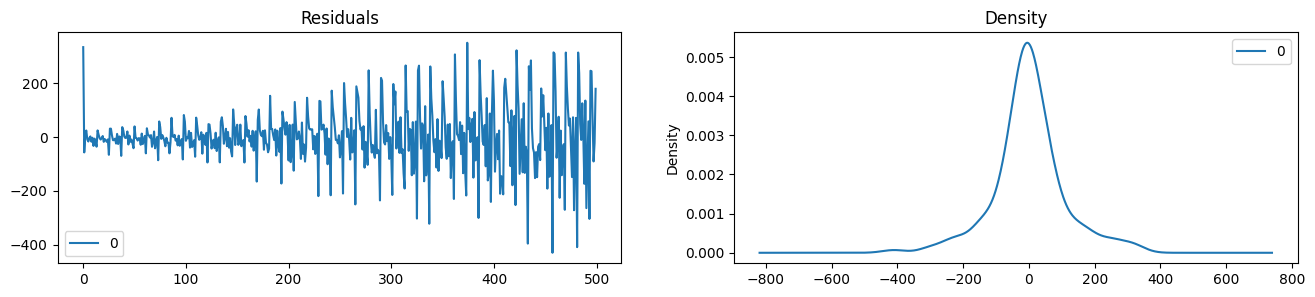

In [106]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

## Step 6 -Cross Validation of Performance Metrics

In [107]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [108]:
forecast_accuracy(forecast, y_test)

{'mape': 0.06087370189643333,
 'me': 269.5326652928211,
 'mae': 270.25830838753245,
 'mpe': 0.06071439846090954,
 'rmse': 324.09985753145196,
 'acf1': 0.19833885163154635,
 'corr': 0.6831606572806287,
 'minmax': 0.05589070675993324}

## Step 7 - Cross validation using TimeSeriesSplit + GridSearch

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX


range_p = [0, 1, 2]
range_d = [1, 2]
range_q = [0, 1, 2]
grid = itertools.product(range_p, range_d, range_q)
orders = []
r2s = []
aics = []
fold_idxs = []
y = y.astype('float32')

for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)

    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(y)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]

        # Using SARIMAX without seasonality or exogenous variables is equivalent to using ARIMA
        # SARIMAX's fit method comes with a maxiter keyword, useful to avoid warnings
        model = SARIMAX(y_train, order=order).fit(maxiter=75, disp=False)
        # model = ARIMA(y_train, order=order).fit()
        y_pred = model.forecast(len(y_test))

        r2s.append(r2_score(y_test, y_pred))
        orders.append(order)
        aics.append(model.aic)


df = pd.DataFrame(list(zip(fold_idxs, orders, aics, r2s)), columns =['Fold', '(p, d, q)', 'AIC', 'R2'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

In [39]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

(p, d, q)
(2, 1, 2)    3318.797502
(1, 2, 2)    3334.408367
(2, 2, 2)    3334.599935
(2, 2, 1)    3336.583696
(1, 2, 1)    3338.510805
(0, 2, 2)    3339.041198
(2, 1, 1)    3343.974782
(2, 1, 0)    3347.141343
(1, 1, 1)    3347.444235
(1, 1, 0)    3347.550702
(1, 1, 2)    3349.057627
(0, 1, 2)    3352.568201
(0, 1, 1)    3358.579480
(2, 2, 0)    3435.239485
(0, 2, 1)    3442.108111
(0, 1, 0)    3447.053005
(1, 2, 0)    3523.252454
(0, 2, 0)    3764.781659
Name: AIC, dtype: float64

In [40]:
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

In [41]:
forecast_results = arima.get_forecast(100, alpha=0.05)
forecast = forecast_results.predicted_mean.reset_index(drop=True)
# forecast = arima.forecast(15, alpha=0.05)
conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


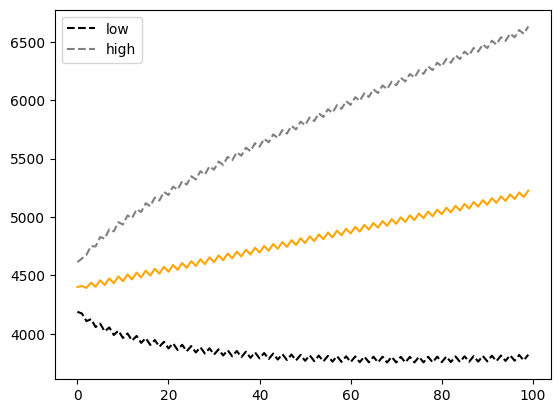

In [42]:
plt.plot(forecast, c='orange')
plt.plot(conf_int['low'], label='low', c='black', ls='--')
plt.plot(conf_int['high'], label='high', c='grey', ls='--')
plt.legend();